# Import

In [1]:
import os
import sys

import json
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

import pytransform3d
from pytransform3d.urdf import UrdfTransformManager
from pytransform3d.plot_utils import make_3d_axis
from urdf_parser_py.urdf import URDF

# Helper Functions

In [2]:
%matplotlib widget

def load_json(filename: str):
    # Construct the absolute path by joining the current directory and relative path
    absolute_path = os.path.join(os.getcwd(), '..', filename)
    # Load the JSON data
    with open(absolute_path, 'r') as file:
        json_data = json.load(file)    
    return json_data

def xml_to_str(robot):
    # To XML string with filtering
    temp_str = robot.to_xml_string()
    words = temp_str.split()
    words[5] = '>'
    urdf_str = ' '.join(words)
    return urdf_str

# Intialization

In [3]:
# Load Configs
cam_mtxs = load_json('camera_mtx.json')
gaze_ctrs = load_json('calib_params.json')
urdf_path = os.path.join(os.getcwd(),"..","urdf","chest_grace.urdf")
robot = URDF.from_xml_file(urdf_path)

# URDF

# URDF Parameters Edit

In [4]:
# URDF Variable Assignment
for joint in robot.joints:
    if joint.name == 'torso':
        joint.origin.position[0] = -0.12234 + 0  # Offset
        joint.origin.position[1] = -0.0325 + 0
        joint.origin.position[2] = 0.05692 + 0
    elif joint.name == 'neck_pitch':
        joint.origin.rotation[0] = 0 + 0
    elif joint.name == 'head_pitch':
        joint.origin.position[2] = 0.13172 + 0
        joint.origin.rotation[0] = 0 + 0
        joint.origin.rotation[2] = 0 + 0
    elif joint.name == 'eyes_pitch':
        joint.origin.position[0] = 0.08492 + 0
        joint.origin.position[2] = 0.05186 + 0
        joint.origin.rotation[0] = 0 + 0
        joint.origin.rotation[2] = 0 + 0
    elif joint.name == 'lefteye_yaw':
        joint.origin.position[1] = 0.02895 + 0
    elif joint.name == 'righteye_yaw':
        joint.origin.position[1] = -0.02895 + 0
    elif joint.name == 'lefteye_cam':
        joint.origin.position[0] = 0.015 + 0
        joint.origin.rotation[0] = 0 + 0
        joint.origin.rotation[1] = 0 + 0.03457662014401592*(-1)  # For Y, Downwards is + because of Camera Opencv Coordinate System
        joint.origin.rotation[2] = 0 + 0.18913797017088096  # Orientation Offset: Right Hand Rule (Positive CCW)
    elif joint.name == 'righteye_cam':
        joint.origin.position[0] = 0.015 + 0
        joint.origin.rotation[0] = 0 + 0
        joint.origin.rotation[1] = 0 + 0.05553511593216458*(-1)  # For Y, Downwards is + because of Camera Opencv Coordinate System
        joint.origin.rotation[2] = 0 + -0.2544206094843146  # Orientation Offset: Right Hand Rule (Positive CCW)
        
# XML to String
urdf_str = xml_to_str(robot)

## Visualize URDF

In [5]:
tm = UrdfTransformManager()
joints_list = ["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"]

In [6]:
tm.load_urdf(urdf_str)

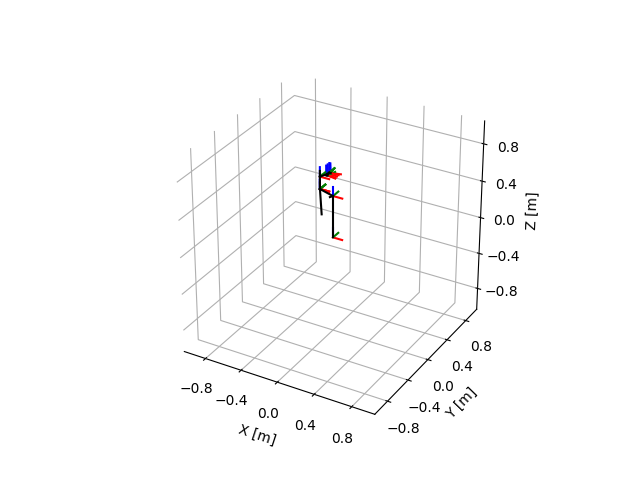

In [7]:
# Visualize
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in("robot", whitelist=joints_list,
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("robot", ax=ax)
plt.show()

## Setting the Joints

In [8]:
# Motor Cmd Value

cmd_lnp = math.radians(10)
cmd_lnt = math.radians(10)
cmd_unt = math.radians(10)
cmd_et = math.radians(10)
cmd_lep = math.radians(5)
cmd_rep = math.radians(5)

In [9]:
# Transforms

neck_pitch = cmd_lnt*0.5 + 0
neck_yaw = cmd_lnp*0.5 + 0
head_pitch = cmd_unt*0.5 + 0
eyes_pitch = cmd_et*0.3 + 0
lefteye_yaw = cmd_lep*1.6 + 0
righteye_yaw = cmd_rep*1.7 + 0

In [10]:
# Setting the Joints

tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

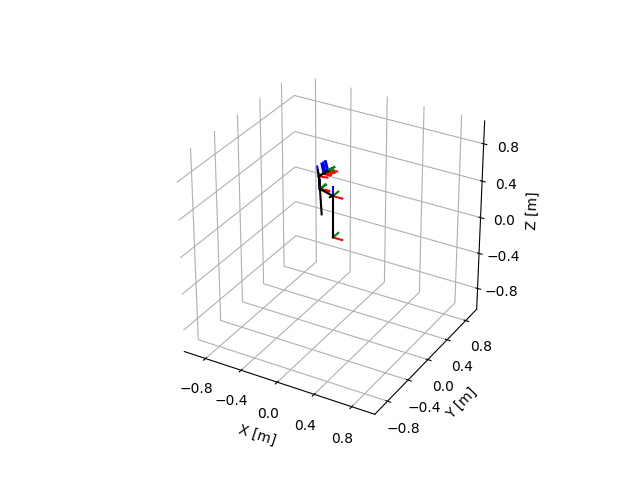

In [11]:
# Visualize
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in("robot", whitelist=joints_list,
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("robot", ax=ax)
plt.show()

# Camera Angle Rotation Offset

## Undistort Points

In [12]:
# Gaze Centers

left_gaze_pt_x = gaze_ctrs['left_eye']['x_center']
left_gaze_pt_y = gaze_ctrs['left_eye']['y_center']
right_gaze_pt_x = gaze_ctrs['right_eye']['x_center']
right_gaze_pt_y = gaze_ctrs['right_eye']['y_center']
print("left_gaze_pt_x:", left_gaze_pt_x)
print("left_gaze_pt_y:", left_gaze_pt_y)
print("right_gaze_pt_x:", right_gaze_pt_x)
print("right_gaze_pt_y:", right_gaze_pt_y)

left_gaze_pt_x: 411
left_gaze_pt_y: 235
right_gaze_pt_x: 151
right_gaze_pt_y: 246


In [13]:
# Normalized Point (z=1.0)
left_undistort_pts = cv2.undistortPoints((left_gaze_pt_x, left_gaze_pt_y), 
                                         np.array(cam_mtxs['left_eye']['camera_matrix']), 
                                         np.array(cam_mtxs['left_eye']['distortion_coefficients']))
right_undistort_pts = cv2.undistortPoints((right_gaze_pt_x, right_gaze_pt_y), 
                                          np.array(cam_mtxs['right_eye']['camera_matrix']), 
                                          np.array(cam_mtxs['right_eye']['distortion_coefficients']))
print('left_undistort_pts:', left_undistort_pts)  # For Y, Downwards is + because of Camera Opencv Coordinate System
print('right_undistort_pts:', right_undistort_pts)  # For Y, Downwards is + because of Camera Opencv Coordinate System

left_undistort_pts: [[[0.19142607 0.03459041]]]
right_undistort_pts: [[[-0.2600561   0.05559228]]]


In [14]:
# Checking of Undistortion
left_pixels,_ = cv2.projectPoints((left_undistort_pts.squeeze()[0], left_undistort_pts.squeeze()[1], 1.0), 
                                np.array([0.0,0.0,0.0]), np.array([0.0,0.0,0.0]), 
                                  np.array(cam_mtxs['left_eye']['camera_matrix']), 
                                  np.array(cam_mtxs['left_eye']['distortion_coefficients']))
right_pixels,_ = cv2.projectPoints((right_undistort_pts.squeeze()[0], right_undistort_pts.squeeze()[1], 1.0), 
                                 np.array([0.0,0.0,0.0]), np.array([0.0,0.0,0.0]), 
                                  np.array(cam_mtxs['right_eye']['camera_matrix']), 
                                  np.array(cam_mtxs['right_eye']['distortion_coefficients']))
print('left_pixels:', left_pixels)
print('right_pixels:',right_pixels)

left_pixels: [[[411. 235.]]]
right_pixels: [[[151.00000002 246.        ]]]


## Orientation Offset Calculation

In [15]:
left_yaw_offset = math.atan2(left_undistort_pts.squeeze()[0],1.0)  # radians unit
left_pitch_offset = math.atan2(left_undistort_pts.squeeze()[1],1.0) # For Y, Downwards is + because of Camera Opencv Coordinate System
right_yaw_offset = math.atan2(right_undistort_pts.squeeze()[0],1.0) 
right_pitch_offset = math.atan2(right_undistort_pts.squeeze()[1],1.0) # For Y, Downwards is + because of Camera Opencv Coordinate System

print('left_yaw_offset(rad):', left_yaw_offset)
print('left_pitch_offset(rad)(opencv coord):', left_pitch_offset)
print('right_yaw_offset:(rad)', right_yaw_offset)
print('right_pitch_offset(rad)(opencv coord):', right_pitch_offset)
print('-----')

print('left_yaw_offset(deg):', math.degrees(left_yaw_offset))
print('left_pitch_offset(deg)(opencv coord):', math.degrees(left_pitch_offset))
print('right_yaw_offset(deg):', math.degrees(right_yaw_offset))
print('right_pitch_offset(deg)(opencv coord):', math.degrees(right_pitch_offset))

left_yaw_offset(rad): 0.18913797017088096
left_pitch_offset(rad)(opencv coord): 0.03457662014401592
right_yaw_offset:(rad) -0.2544206094843146
right_pitch_offset(rad)(opencv coord): 0.05553511593216458
-----
left_yaw_offset(deg): 10.836807436462736
left_pitch_offset(deg)(opencv coord): 1.981094404079137
right_yaw_offset(deg): -14.57722714459731
right_pitch_offset(deg)(opencv coord): 3.1819277576827667


# Generate Dataset

## Proving

In [16]:
mat = tm.get_transform('realsense','leftcamera')
mat

array([[ 0.96538347, -0.03645733,  0.25827429, -0.02573908],
       [ 0.03868054,  0.99924539, -0.00353007,  0.01655289],
       [-0.2579507 ,  0.01339806,  0.96606518, -0.25957355],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [17]:
# Example

in_pts = np.array([0.5,0.8,0.75,1]).reshape(-1,1)
out_pts = mat @ in_pts
print('in_pts:',in_pts)
print('out_pts:',out_pts)

in_pts: [[0.5 ]
 [0.8 ]
 [0.75]
 [1.  ]]
out_pts: [[0.62149252]
 [0.83264192]
 [0.34671844]
 [1.        ]]


In [18]:
# Solution
x_prime = out_pts[0,0]/out_pts[2,0]
y_prime = out_pts[1,0]/out_pts[2,0]
a = np.array([[mat[0,0],mat[0,1],-x_prime],
              [mat[1,0],mat[1,1],-y_prime],
              [mat[2,0],mat[2,1],-1]])
b = np.array([-mat[0,2]*in_pts[2,0]-mat[0,3], -mat[1,2]*in_pts[2,0]-mat[1,3], -mat[2,2]*in_pts[2,0]-mat[2,3]])
x = np.linalg.solve(a, b)
x

array([0.5       , 0.8       , 0.34671844])

In [19]:
# Function Prototype

x_prime = out_pts[0,0]/out_pts[2,0]
y_prime = out_pts[1,0]/out_pts[2,0]
z = in_pts[2,0]

a = np.array([[mat[0,0],mat[0,1],-x_prime],
              [mat[1,0],mat[1,1],-y_prime],
              [mat[2,0],mat[2,1],-1]])
b = np.array([-mat[0,2]*z-mat[0,3], -mat[1,2]*z-mat[1,3], -mat[2,2]*z-mat[2,3]])
x = np.linalg.solve(a, b)
x

array([0.5       , 0.8       , 0.34671844])

In [20]:
def generate_chest_dataset(mat, z, x_prime, y_prime):
    a = np.array([[mat[0,0],mat[0,1],-x_prime],
              [mat[1,0],mat[1,1],-y_prime],
              [mat[2,0],mat[2,1],-1]])
    b = np.array([-mat[0,2]*z-mat[0,3], -mat[1,2]*z-mat[1,3], -mat[2,2]*z-mat[2,3]])
    x = np.linalg.solve(a, b)
    return x[:2]

In [21]:
# Testing the Function
generate_chest_dataset(mat=mat, z=in_pts[2,0], x_prime=out_pts[0,0]/out_pts[2,0], y_prime=out_pts[1,0]/out_pts[2,0])

array([0.5, 0.8])